<h1>
    Thermodynamics of Materials AD19: <br>
    <b>Class Activity 03</b>
</h1>

<table width="75%" align="center">
    <tr>
        <th align="left" colspan="2">
            <h2><b>Team<b>:</b></h2>
        </th>
    </tr>
    <tr>
        <td><h3>Antonio Osamu Katagiri Tanaka</h3></td>
        <td><h4>A01212611@itesm.mx</h4></td>
    </tr>
</table>

---

<h1>Binary Phase Diagrams</h1>

In [2]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from scipy.optimize import least_squares, fsolve, curve_fit

$$ \Delta G_{m,A} = 8000 - 10 T [J/mol] $$
$$ \Delta G_{m,B} = 12000 - 10 T [J/mol] $$

In [3]:
def DG_mA_(T):
    return 8000 - 10*T;

def DG_mB_(T):
    return 12000 - 10*T;

$$ \Omega_l = -20000 [J/mol] $$
$$ \Omega_s = 0 [J/mol] $$

In [4]:
Omega_l = -20000
Omega_s = 0

$$ \Delta G_s = - x_A \Delta G_{m,A} + R T (x_A ln x_A + x_B ln x_B) + \Omega_s x_A x_B  $$
$$ \Delta G_l = x_B \Delta G_{m,B} + R T (x_A ln x_A + x_B ln x_B) + \Omega_l x_A x_B $$

$$ G_{B,s} = 0 $$
$$ G_{A,l} = 0 $$

Substituing numerical values ...

$$ \Delta G_s = (10 T-8000) \left(1-x_B\right)+8.3144 T \left(\left(1-x_B\right) \log \left(1-x_B\right)+x_B \log \left(x_B\right)\right) $$

$$ \Delta G_l = (12000-10 T) x_B+8.3144 T \left(\left(1-x_B\right) \log \left(1-x_B\right)+x_B \log \left(x_B\right)\right)-20000 x_B \left(1-x_B\right) $$

In [5]:
def DG_s_(xb, T, Omega_s):
    DG_mA = DG_mA_(T)
    R = 8.3144
    xa = 1 - xb
    return -xa*DG_mA + R*T*(xa*np.log(xa) + xb*np.log(xb)) + Omega_s*xa*xb;
def d_DG_s_(xb, T):
    return 8.3144*T*(np.log(xb) - np.log(1 - xb)) - 10*T + 8000

def DG_l_(xb, T, Omega_l):
    DG_mB = DG_mB_(T)
    R = 8.3144
    xa = 1 - xb
    return xb*DG_mB + R*T*(xa*np.log(xa) + xb*np.log(xb)) + Omega_l*xa*xb;
def d_DG_l_(xb, T):
    return 8.3144*T*(np.log(xb) - np.log(1 - xb)) - 20000*(1 - xb) + 20000*xb - 10*T + 12000


def mu_1s_(xb, T, Omega_s):
    return DG_s_(xb, T, Omega_s) - xb*d_DG_s_(xb, T)
def mu_2s_(xb, T, Omega_s):
    return DG_s_(xb, T, Omega_s) + (1 - xb)*d_DG_s_(xb, T)

def mu_1l_(xb, T, Omega_l):
    return DG_l_(xb, T, Omega_l) - xb*d_DG_l_(xb, T)
def mu_2l_(xb, T, Omega_l):
    return DG_l_(xb, T, Omega_l) + (1 - xb)*d_DG_l_(xb, T)

PLOT

>>> solid
nan
nan


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

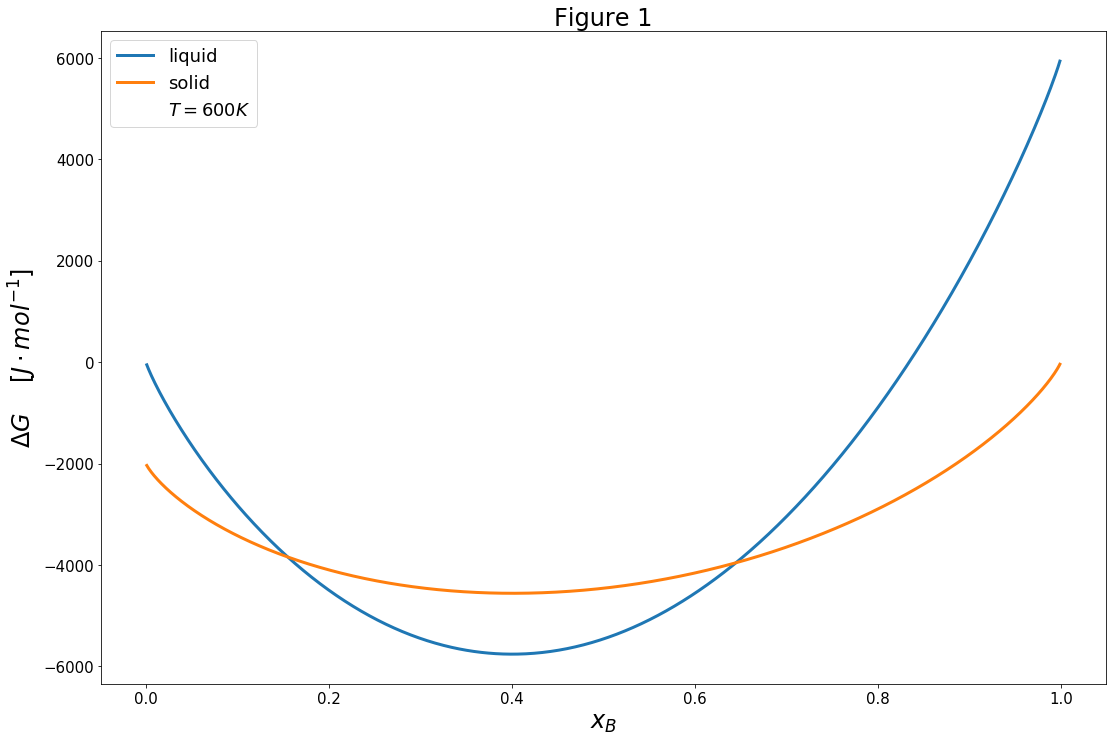

In [7]:
T = 600
xb = np.linspace(0.0, 1.0, 1000) 

print('>>> solid')
print(mu_1s_(0.316228, T, Omega_s))
print(mu_1l_(0.316228, T, Omega_s))
#print('>>> liquid')
#print(mu_1l_(0.0000001, T, Omega_s))
#print(mu_2l_(0.9999999, T, Omega_s))

# PLOT FIG
scale = 6;
fig, ax = plt.subplots(figsize=(3*scale, 2*scale));

# Plot
#plt.scatter(T, C, s=25, color='red', label='Raw data');
x = xb
y = DG_l_(xb, T, Omega_l)
plt.plot(x, y, '-', linewidth=3, label='liquid')

x = xb
y = DG_s_(xb, T, Omega_s)
plt.plot(x, y, '-', linewidth=3, label='solid')

# Print fitting parameters as plot legends
x = x[0]
y = y[0]
plt.scatter(x, y, s=0, label=r'$T = $' + str(round(T, 2)) + r'$K$')

# Display plots
plt.yscale('linear');
plt.xlabel(r'$x_B$', fontsize=24);
plt.ylabel(r'$\Delta G$' + '    ' + r'$[J \cdot mol^{-1}]$', fontsize=24);
plt.title('Figure 1', size=24);
plt.legend(prop={'size': 18});
display(plt);

In [ ]:
'''
from sympy import symbols, Eq, solve
from sympy.functions import log as smlog

a, c = symbols('a c')

eq1 = Eq(8.3144*T*(smlog(c) - smlog(1 - c)) - 10*T + 8000)
eq2 = Eq(8.3144*T*(smlog(a) - smlog(1 - a)) - 20000*(1 - a) + 20000*a - 10*T + 12000)

sol = solve((eq1, eq2),(a, c))
sol
'''